# Evaluation

## Loading

In [50]:
# Import libraries
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from mlres.modules.networks import WaveNet
from mlres.dataset import GermanWeatherEnergy

In [85]:
# Define hyperparameters
n_layers = 9
target_idx = 1202
n_channels = 256
window_size = 288
horizon = 96
results_dir = "/home/martius-lab/Desktop/renewable_ml/cluster_results/"
data_dir = "/home/martius-lab/Desktop/renewable_ml/data/"
name_run = 'photovoltaic/2020_49ff077411ad07791c532f00b365526b'
loss_log_frequency = 10

In [58]:
# Load data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weather_energy_data = GermanWeatherEnergy(target_idx=target_idx, 
                                          window_size=window_size, 
                                          horizon=horizon, 
                                          data_dir=data_dir, 
                                          device=device)

Loading and preprocessing data...
Loaded weather data in 5.97 seconds.
Loaded energy data in 0.85 seconds.
Merged realisation data in 0.02 seconds.
Converted to datetime format in 0.78 seconds.
Converted energy data to UTC in 0.02 seconds.
Filled missing weather data in 19.74 seconds.
Stacked locations in 44.88 seconds.
Filled missing energy data in 0.70 seconds.
Combined weather and energy data in 1.84 seconds.
Split time into integers in 0.07 seconds.
Split data into training and validation sets in 0.82 seconds.
Normalized data in 6.16 seconds.
Processed data generated successfully.


In [86]:
weather_energy_data.target_idx = target_idx
weather_energy_data.window_size = window_size

In [87]:
# Get the test data and create the loader
train_data, val_data = weather_energy_data.get_train_and_val_data()
test_data = weather_energy_data.get_test_data()
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [88]:
# Load the model
n_features = test_data.data.shape[1]
model = WaveNet(n_layers=n_layers, n_input_channels=n_features, n_channels=n_channels, window_size=window_size, horizon=horizon).to(device)
model.load_state_dict(torch.load(os.path.join(results_dir, name_run, 'best_model.pth')))
model.eval()

WaveNet(
  (layers): ModuleList(
    (0): DilatedConvLayer1d(
      (conv): Conv1d(1219, 256, kernel_size=(2,), stride=(1,))
      (activation): ReLU()
      (residual): Conv1d(1219, 256, kernel_size=(1,), stride=(1,))
    )
    (1): DilatedConvLayer1d(
      (conv): Conv1d(256, 256, kernel_size=(2,), stride=(1,), dilation=(2,))
      (activation): ReLU()
      (residual): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
    (2): DilatedConvLayer1d(
      (conv): Conv1d(256, 256, kernel_size=(2,), stride=(1,), dilation=(4,))
      (activation): ReLU()
      (residual): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
    (3): DilatedConvLayer1d(
      (conv): Conv1d(256, 256, kernel_size=(2,), stride=(1,), dilation=(8,))
      (activation): ReLU()
      (residual): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
    (4): DilatedConvLayer1d(
      (conv): Conv1d(256, 256, kernel_size=(2,), stride=(1,), dilation=(16,))
      (activation): ReLU()
      (residual): Conv1d(2

## Experimentation

### Whole test dataset

In [89]:
# Initialize the loss and criterion
criterion = torch.nn.L1Loss()
RMSE = lambda x, y: torch.sqrt(torch.nn.MSELoss()(x, y))
total_test_loss = 0
total_rmse = 0

In [90]:
# Compute the losses
for i, (x, y) in enumerate(test_loader):
    with torch.no_grad():
        y_hat = model(torch.transpose(x, 2, 1)).reshape(y.shape)
        loss = criterion(y_hat, y)
        rmse = RMSE(y[-1], y_hat[-1])
        total_test_loss += loss.item()
        total_rmse += rmse.item()
        if i % loss_log_frequency == 0:
            print(f"Test Batch {i}, Loss: {loss.item()}, RMSE: {rmse.item()}")
test_loss = total_test_loss / len(test_loader)
test_rmse = total_rmse / len(test_loader)
print(f"Test Loss: {test_loss}")
print(f"RMSE: {test_rmse}")

Test Batch 0, Loss: 102.54953002929688, RMSE: 207.44326782226562
Test Batch 10, Loss: 104.79112243652344, RMSE: 242.5322723388672
Test Batch 20, Loss: 30.80617904663086, RMSE: 61.549156188964844
Test Batch 30, Loss: 37.228797912597656, RMSE: 77.94087982177734
Test Batch 40, Loss: 46.71116256713867, RMSE: 94.45216369628906
Test Batch 50, Loss: 53.53037643432617, RMSE: 109.53829956054688
Test Batch 60, Loss: 191.97006225585938, RMSE: 396.17291259765625
Test Batch 70, Loss: 99.4249267578125, RMSE: 109.7126235961914
Test Batch 80, Loss: 29.451200485229492, RMSE: 55.91123580932617
Test Batch 90, Loss: 60.770042419433594, RMSE: 117.92109680175781
Test Batch 100, Loss: 39.954978942871094, RMSE: 79.07279205322266
Test Batch 110, Loss: 105.70848846435547, RMSE: 179.2920379638672
Test Batch 120, Loss: 53.4945182800293, RMSE: 99.56546783447266
Test Batch 130, Loss: 114.96481323242188, RMSE: 347.5014953613281
Test Batch 140, Loss: 130.6136474609375, RMSE: 213.90896606445312
Test Batch 150, Loss: 4

### Single example from the test dataset

In [103]:
# Load the example
example_number = 5320
example = test_data[example_number]
start_time = weather_energy_data.test_data['time'][example_number]
inputs, targets = example

In [104]:
# Obtain the forecast
outputs = model(torch.transpose(inputs[None, ...], 2, 1)).reshape(targets.shape)
print(criterion(outputs[-1], targets[-1]).item())

1066.11083984375


In [105]:
# Prepare the data for plotting
x_window = start_time + np.arange(len(inputs)) * pd.Timedelta(minutes=15)
x_horizon = start_time + (np.arange(len(outputs) + 1) + len(x_window) - 1) * pd.Timedelta(minutes=15)
y_window = inputs[:, target_idx].cpu().detach().numpy()
y_forecast = np.append([y_window[-1]], outputs.cpu().detach().numpy())
y_ground_truth = np.append([y_window[-1]], targets.cpu().detach().numpy())

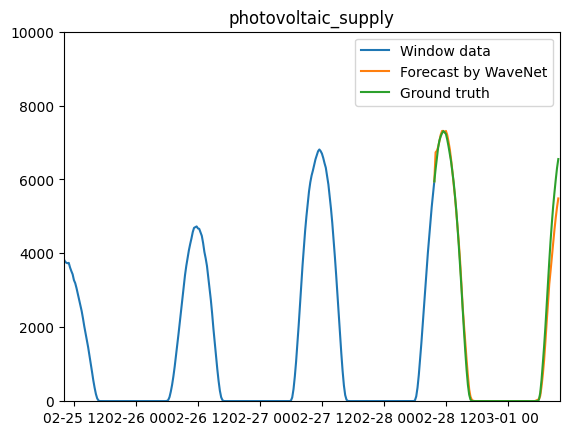

In [106]:
# Plot the data
plt.title(test_data.data.columns[target_idx])
plt.ylim(-5, 10000)
plt.xlim(start_time, start_time + (window_size + horizon) * pd.Timedelta(minutes=15))

plt.plot(x_window, y_window, label='Window data')
plt.plot(x_horizon, y_forecast, label='Forecast by WaveNet')
plt.plot(x_horizon, y_ground_truth, label='Ground truth')
plt.legend()

plt.savefig('result.png')
plt.show()

In [114]:
test_data.data.columns[:16]

Index(['cdir_loc0', 'z_loc0', 'msl_loc0', 'blh_loc0', 'tcc_loc0', 'u10_loc0',
       'v10_loc0', 't2m_loc0', 'ssr_loc0', 'tsr_loc0', 'sund_loc0', 'tp_loc0',
       'fsr_loc0', 'u100_loc0', 'v100_loc0', 'cdir_loc1'],
      dtype='object')